# Stage 0: SETUP
The following libraries are used directly. For the full list of installed packages and versions, please see requirements.txt

In [3]:
# Imports
import pandas as pd
import numpy as np

# Stage 1: DATA ACQUISITION

Data is downloaded as csv files, and is already available in this repository in the data folder. See the readme for details on the source of the data.

## Case Data
Case data is provided with dates as columns. For processing, the data is melted into a "date" column and "case_count" column, and unused columns are dropped.

In [4]:
# Get raw data, only keep used columns
raw_case_data = pd.read_csv('data/raw/RAW_us_confirmed_cases.csv').drop(columns = ["Province_State", "Admin2", "UID", "iso2", "iso3", "Country_Region", "Lat", "Long_", "code3", "Combined_Key"])


# Pivot into dat column
case_data = raw_case_data.melt(id_vars = "FIPS", var_name="date", value_name = "Case_Count").dropna(subset=['FIPS'])

# Cast types
case_data["date"] = pd.to_datetime(case_data["date"])
case_data["FIPS"] = case_data["FIPS"].astype(int).astype(str).str.pad(5, 'left', '0')
case_data.head()


,FIPS,date,Case_Count
0,01001,2020-01-22,0
1,01003,2020-01-22,0
2,01005,2020-01-22,0
3,01007,2020-01-22,0
4,01009,2020-01-22,0


## Compliance Data


In [5]:
# Get raw data
raw_compliance_data = pd.read_csv('data/raw/mask_use_by_county.csv')
raw_compliance_data["FIPS"] = raw_compliance_data['COUNTYFP'].astype(str).str.pad(5, 'left', '0')

# Combine into single score
raw_compliance_data["mask_compliance"] = np.dot(raw_compliance_data.iloc[:,1:6], [0, 0.25, 0.5, 0.75, 1])

# Clean
compliance_data = raw_compliance_data[["FIPS", "mask_compliance"]]
compliance_data.head()

,FIPS,mask_compliance
0,01001,0.75075
1,01003,0.74200
2,01005,0.73200
3,01007,0.83700
4,01009,0.72300


## Housing Data

In [6]:
# Get raw data, only keep used columns
use_cols = ["fips2010", "n_units", "li_units"]
raw_housing_data = pd.read_csv('data/raw/LIHTCPUB.CSV', usecols=use_cols)
raw_housing_data["FIPS"] = raw_housing_data["fips2010"].str[:5]

housing_data = raw_housing_data.drop(columns=["fips2010"]).groupby("FIPS").sum()
housing_data.head()

,n_units,li_units
FIPS,,
01001,499.0,499.0
01003,1963.0,1920.0
01005,413.0,413.0
01007,278.0,278.0
01009,275.0,275.0


## Demographic Data

In [7]:
# INCOME
# Get raw data, only keep used columns
use_cols = ["id", "Estimate!!Households!!Total", "Estimate!!Households!!Mean income (dollars)"]
raw_income_data = pd.read_csv('data/raw/income_census_data_2019.csv', header=1, usecols=use_cols)
raw_income_data.columns= ["FIPS", "household_count", "mean_income"]
raw_income_data["FIPS"] = raw_income_data["FIPS"].str[-5:]

# POPULATION
# Get raw data, only keep used columns
use_cols = ["id", "Estimate!!SEX AND AGE!!Total population"]
raw_population_data = pd.read_csv('data/raw/population_census_data_2019.csv', header=1, usecols=use_cols)
raw_population_data.columns= ["FIPS", "population"]
raw_population_data["FIPS"] = raw_population_data["FIPS"].str[-5:]

# Combine
demographic_data = raw_income_data.merge(raw_population_data, on="FIPS", how='inner')
demographic_data.head()

,FIPS,household_count,mean_income,population
0,13013,27765,77081,83240
1,13015,39742,70644,107738
2,13021,56726,67678,153159
3,13031,28660,61191,79608
4,13045,42798,69895,119992


# Stage 2: DATA PROCESSING

Merge the data on FIPS

In [8]:
# Combine on FIPS
combined_data = case_data.merge(compliance_data, on="FIPS", how='left')
combined_data = combined_data.merge(housing_data,on="FIPS", how='left')
combined_data = combined_data.merge(demographic_data,on="FIPS", how='left')
combined_data.head()

,FIPS,date,Case_Count,mask_compliance,n_units,li_units,household_count,mean_income,population
0,01001,2020-01-22,0,0.75075,499.0,499.0,NaN,NaN,NaN
1,01003,2020-01-22,0,0.74200,1963.0,1920.0,NaN,NaN,NaN
2,01005,2020-01-22,0,0.73200,413.0,413.0,NaN,NaN,NaN
3,01007,2020-01-22,0,0.83700,278.0,278.0,NaN,NaN,NaN
4,01009,2020-01-22,0,0.72300,275.0,275.0,NaN,NaN,NaN


Normalize housing data on household count


In [59]:
combined_data["n_units_per_household"] = combined_data["n_units"] / combined_data["household_count"]
combined_data["li_units_per_household"] = combined_data["li_units"] / combined_data["household_count"]

Add extra calculations per fip

In [60]:
# Assumed variables
active_window = 14 # Days after infection that case is active

# Calculations per FIP
combined_data.sort_values(by="date", inplace=True)

# Do rolling average of cases to account for weekly fluctiation
grouped = combined_data.groupby("FIPS")
combined_data["Case_Count_7da"] = grouped["Case_Count"].rolling(window=7).mean().reset_index(0,drop=True)
grouped = combined_data.groupby("FIPS")
combined_data["new_cases"] = grouped["Case_Count_7da"].diff().reset_index(0,drop=True).rolling(window=7).mean()
grouped = combined_data.groupby("FIPS")
combined_data["active_cases"] = grouped["new_cases"].rolling(window=active_window).sum().reset_index(0,drop=True)
combined_data["vulnerable_pop"] = combined_data["population"] - combined_data["Case_Count_7da"]

combined_data[combined_data["FIPS"] == '13135'].head()

,FIPS,date,Case_Count,mask_compliance,n_units,li_units,household_count,mean_income,population,Case_Count_7da,new_cases,active_cases,vulnerable_pop,n_units_per_househould,li_units_per_househould,n_units_per_household,li_units_per_household
477,13135,2020-01-22,0,0.8355,4746.0,2810.0,301471.0,93401.0,936250.0,NaN,NaN,NaN,NaN,0.015743,0.009321,0.015743,0.009321
3809,13135,2020-01-23,0,0.8355,4746.0,2810.0,301471.0,93401.0,936250.0,NaN,NaN,NaN,NaN,0.015743,0.009321,0.015743,0.009321
7141,13135,2020-01-24,0,0.8355,4746.0,2810.0,301471.0,93401.0,936250.0,NaN,NaN,NaN,NaN,0.015743,0.009321,0.015743,0.009321
10473,13135,2020-01-25,0,0.8355,4746.0,2810.0,301471.0,93401.0,936250.0,NaN,NaN,NaN,NaN,0.015743,0.009321,0.015743,0.009321
13805,13135,2020-01-26,0,0.8355,4746.0,2810.0,301471.0,93401.0,936250.0,NaN,NaN,NaN,NaN,0.015743,0.009321,0.015743,0.009321


Filter down to jsut the Atlanta area counties

In [61]:
# Filter down to Atlanta counties
county_fips = [
    '13057', #Cherokee
    '13063', #Clayton
    '13067', #Cobb
    '13089', #DeKalb
    '13097', #Douglas
    '13113', #Fayette
    '13117', #Forsyth
    '13121', #Fulton
    '13135', #Gwinettt
    '13151', #Henry
    '13247', #Rockdale
]
combined_data_atl = combined_data[combined_data["FIPS"].isin(county_fips)].copy()
combined_data_atl.dropna(subset=["active_cases", "population", "vulnerable_pop", "new_cases", "FIPS"])
combined_data_atl.head()

,FIPS,date,Case_Count,mask_compliance,n_units,li_units,household_count,mean_income,population,Case_Count_7da,new_cases,active_cases,vulnerable_pop,n_units_per_househould,li_units_per_househould,n_units_per_household,li_units_per_household
533,13247,2020-01-22,0,0.77300,288.0,180.0,32792.0,78651.0,90896.0,NaN,NaN,NaN,NaN,0.008783,0.005489,0.008783,0.005489
453,13089,2020-01-22,0,0.86550,14612.0,5618.0,289829.0,94336.0,759297.0,NaN,NaN,NaN,NaN,0.050416,0.019384,0.050416,0.019384
466,13113,2020-01-22,0,0.75550,569.0,337.0,41253.0,128190.0,114421.0,NaN,NaN,NaN,NaN,0.013793,0.008169,0.013793,0.008169
443,13067,2020-01-22,0,0.81100,6727.0,2278.0,286952.0,108459.0,760141.0,NaN,NaN,NaN,NaN,0.023443,0.007939,0.023443,0.007939
458,13097,2020-01-22,0,0.79375,811.0,316.0,48899.0,80676.0,146343.0,NaN,NaN,NaN,NaN,0.016585,0.006462,0.016585,0.006462


# Stage 3: MODELING

Here we model infection rates and case counts. The model is 

$$
C_{new} = P_v(1 - (1 - r)^{\frac{C_{active}}{P_{total}}x})
$$

Where $C_{new}$ and $C_{active}$ are new and active cases, $P_v$ and $P_{total}$ are vulnerable and total population, r is the transmission rate and x is the exposure rate.

In [62]:
def transmissionModel(data, r, x):
    c_active = data["active_cases"]
    p_total = data["population"]
    p_vuln = data["vulnerable_pop"]
    daily_exposures = c_active / p_total * x
    return p_vuln * (1 - pow( 1 - r,daily_exposures))

We fit r and x to a dataset. r is bound between 0 and 1, since it's a probability, and x is bounded from 1 to 1000 to help in optimizing the curve fit.

In [78]:
from scipy.optimize import curve_fit

def getTransmissionVariables(data):
    y = data["new_cases"]
    X = data[["active_cases", "population", "vulnerable_pop"]]
    
    #Don't model blank periods
    if y.sum() <= 0:
        return (np.NaN, np.NaN)
    
    popt, pcov = curve_fit(transmissionModel, X, y, p0 = [0.03, 3], bounds=(0, [1,1000]))
    return popt


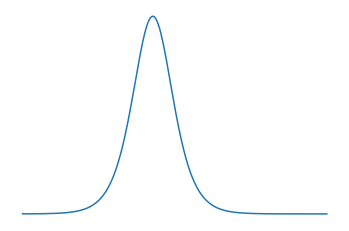

In [141]:
# Simulate 
p_t = 1000000
p_v = p_t
new_cases = [10]
active_cases = new_cases[0]
r = 0.001
x = 100
while p_v > 0 and active_cases >= 1:
    active_cases = np.sum(new_cases[-14:])
    data = {"active_cases": active_cases, "population": p_t, "vulnerable_pop": p_v}
    new_cases.append(transmissionModel(data, r, x))
    p_v -= new_cases[-1]

#Plot
plt.plot(new_cases)
plt.axis('off')
# title_obj = plt.title('High Transmission Low Exposure')
# plt.setp(title_obj, color='g')
plt.show()

For each month in each county, we calculate the values

In [79]:
# Group by month
combined_data_atl["month"] = combined_data_atl["date"].dt.strftime('%y-%m')

# Drill down to specific columns and drop na
model_data = combined_data_atl[["FIPS", "month", "new_cases","active_cases", "population", "vulnerable_pop"]].dropna()

#Groupby month and apply
model_fits = model_data.groupby(["FIPS", "month"]).apply(getTransmissionVariables)
model_fits.columns = ["x"]
model_fits = pd.DataFrame(model_fits.tolist(), index=model_fits.index, columns = ["transmission_chance", "exposure_rate"])

# Merge results back into combined data
modeled_data = combined_data_atl.merge(model_fits, on=["FIPS", "month"]).dropna()
modeled_data["modeled_new_cases"] = transmissionModel(modeled_data, modeled_data["transmission_chance"], modeled_data["exposure_rate"])
modeled_data.head()

,FIPS,date,Case_Count,mask_compliance,n_units,li_units,household_count,mean_income,population,Case_Count_7da,...,active_cases,vulnerable_pop,n_units_per_househould,li_units_per_househould,n_units_per_household,li_units_per_household,month,transmission_chance,exposure_rate,modeled_new_cases
319,13247,2020-03-01,0,0.773,288.0,180.0,32792.0,78651.0,90896.0,0.0,...,1.136868e-13,90896.0,0.008783,0.005489,0.008783,0.005489,20-03,0.031196,5.053622,0.0
320,13247,2020-03-02,0,0.773,288.0,180.0,32792.0,78651.0,90896.0,0.0,...,1.136868e-13,90896.0,0.008783,0.005489,0.008783,0.005489,20-03,0.031196,5.053622,0.0
321,13247,2020-03-03,0,0.773,288.0,180.0,32792.0,78651.0,90896.0,0.0,...,1.136868e-13,90896.0,0.008783,0.005489,0.008783,0.005489,20-03,0.031196,5.053622,0.0
322,13247,2020-03-04,0,0.773,288.0,180.0,32792.0,78651.0,90896.0,0.0,...,1.136868e-13,90896.0,0.008783,0.005489,0.008783,0.005489,20-03,0.031196,5.053622,0.0
323,13247,2020-03-05,0,0.773,288.0,180.0,32792.0,78651.0,90896.0,0.0,...,1.136868e-13,90896.0,0.008783,0.005489,0.008783,0.005489,20-03,0.031196,5.053622,0.0


We can see how close our fit was for Gwinett

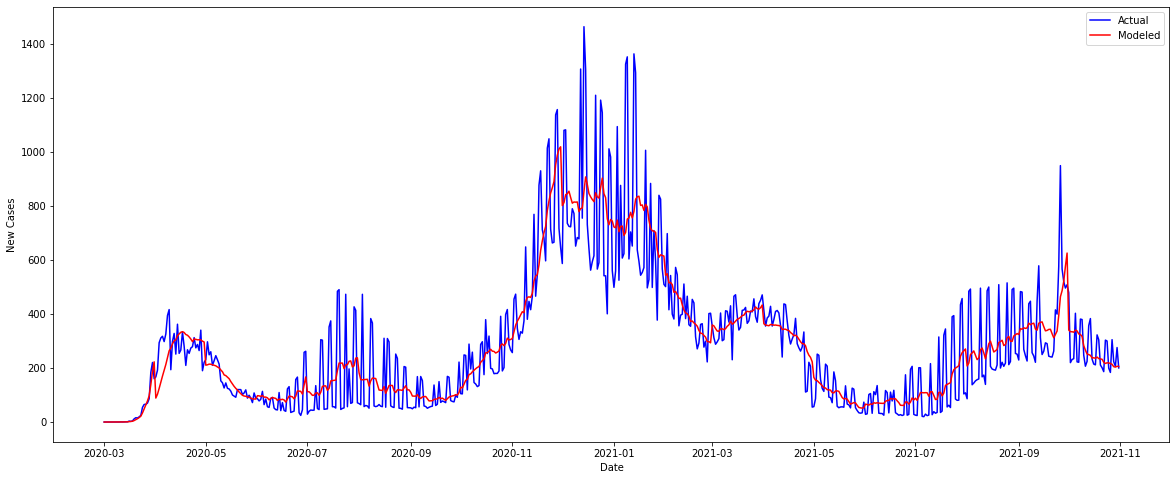

In [154]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


#target_county = modeled_data[modeled_data["FIPS"] == '13135']
target_county = modeled_data.groupby("date").sum().reset_index()

plt.figure(figsize=(20,8))
plt.plot(target_county["date"], target_county["new_cases"], 'b-', label='Actual')
plt.plot(target_county["date"], target_county["modeled_new_cases"], 'r-', label='Modeled')

plt.xlabel('Date')
plt.ylabel('New Cases')

plt.legend()
plt.show()

# Stage 4: ANALYSIS

We now analyze how our demogrpahic data relates to the modelled parameters

Each month is a data point

In [89]:
x_vars = ["mask_compliance", "n_units_per_household", "li_units_per_household", "household_count", "mean_income", "active_cases"]
y_vars = ["transmission_chance", "exposure_rate"]
monthly = modeled_data.groupby(["FIPS", "month"])[x_vars + y_vars].mean()
X = monthly[x_vars]
monthly

mask_compliance  n_units_per_household  li_units_per_household  \
FIPS  month                                                                   
13057 20-03          0.80725               0.031111                0.008294   
      20-04          0.80725               0.031111                0.008294   
      20-05          0.80725               0.031111                0.008294   
      20-06          0.80725               0.031111                0.008294   
      20-07          0.80725               0.031111                0.008294   
...                      ...                    ...                     ...   
13247 21-06          0.77300               0.008783                0.005489   
      21-07          0.77300               0.008783                0.005489   
      21-08          0.77300               0.008783                0.005489   
      21-09          0.77300               0.008783                0.005489   
      21-10          0.77300               0.008783                0.005489   

             household_count  mean_income  active_cases  transmission_chance  \
FIPS  month                                                                    
13057 20-03          93441.0     101950.0      5.350889             0.035240   
      20-04          93441.0     101950.0     61.298639             0.028925   
      20-05          93441.0     101950.0     70.715602             0.027651   
      20-06          93441.0     101950.0    135.306803             0.031094   
      20-07          93441.0     101950.0    528.686636             0.028775   
...                      ...          ...           ...                  ...   
13247 21-06          32792.0      78651.0      6.049660             0.027445   
      21-07          32792.0      78651.0      3.897959             0.027978   
      21-08          32792.0      78651.0     20.354180             0.030478   
      21-09          32792.0      78651.0     54.579592             0.030028   
      21-10          32792.0      78651.0     89.227781             0.028288   

             exposure_rate  
FIPS  month                 
13057 20-03       5.818015  
      20-04       2.895767  
      20-05       2.652629  
      20-06       4.277621  
      20-07       2.890552  
...                    ...  
13247 21-06       2.652856  
      21-07       2.817725  
      21-08       3.164009  
      21-09       3.115838  
      21-10       2.848954  

[220 rows x 8 columns]

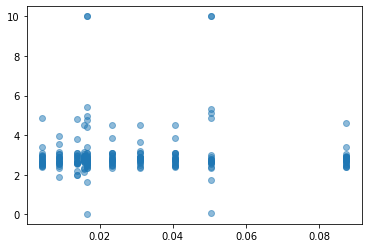

In [82]:
plt.plot(X['n_units_per_household'],y, 'o', alpha=0.5);

### Transmission Chance

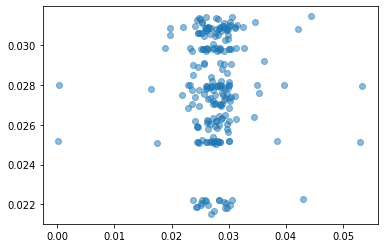

<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Results: Generalized linear model
=========================================================================
Model:                 GLM                   AIC:              56.0206   
Link Function:         logit                 BIC:              -1153.9384
Dependent Variable:    transmission_chance   Log-Likelihood:   -22.010   
Date:                  2021-12-04 14:47      LL-Null:          -21.982   
No. Observations:      220                   Deviance:         0.29790   
Df Model:              5                     Pearson chi2:     0.265     
Df Residuals:          214                   Scale:            1.0000    
Method:                IRLS                                              
-------------------------------------------------------------------------
                        Coef.  Std.Err.    z    P>|z|    [0.025   0.975] 
-------------------------------------------------------------------------
mask_compliance        -4.4346   2.5852 -1.7154 0.0863   -9.5015   0.6322
n_units_per_household   2.5098  79.9934  0.0314 0.9750 -154.2744 159.2939
li_units_per_household -5.3943 204.8937 -0.0263 0.9790 -406.9786 396.1900
household_count         0.0000   0.0000  0.1756 0.8606   -0.0000   0.0000
mean_income            -0.0000   0.0000 -0.0476 0.9621   -0.0000   0.0000
active_cases           -0.0000   0.0009 -0.0432 0.9655   -0.0019   0.0018
=========================================================================

"""

In [90]:
import statsmodels.api as sm

y = monthly["transmission_chance"]
binom_glm = sm.GLM(y, X, family=sm.families.Binomial())
binom_results = binom_glm.fit()

plt.plot(y, binom_results.predict(X), 'o', alpha=0.5);
plt.show()
binom_results.summary2()


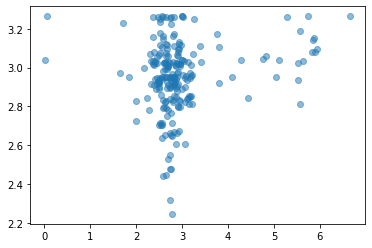

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Results: Generalized linear model
=======================================================================
Model:                 GLM                 AIC:               572.3719 
Link Function:         identity            BIC:               -989.7388
Dependent Variable:    exposure_rate       Log-Likelihood:    -280.19  
Date:                  2021-12-04 14:43    LL-Null:           -282.81  
No. Observations:      220                 Deviance:          164.50   
Df Model:              5                   Pearson chi2:      164.     
Df Residuals:          214                 Scale:             0.76868  
Method:                IRLS                                            
-----------------------------------------------------------------------
                        Coef.  Std.Err.    z    P>|z|   [0.025   0.975]
-----------------------------------------------------------------------
mask_compliance         3.9144   0.3741 10.4632 0.0000   3.1811  4.6476
n_units_per_household   1.3917  11.5292  0.1207 0.9039 -21.2051 23.9885
li_units_per_household -6.5851  29.7316 -0.2215 0.8247 -64.8579 51.6878
household_count        -0.0000   0.0000 -0.0420 0.9665  -0.0000  0.0000
mean_income            -0.0000   0.0000 -0.2124 0.8318  -0.0000  0.0000
active_cases           -0.0003   0.0001 -2.5503 0.0108  -0.0006 -0.0001
=======================================================================

"""

In [84]:
y = monthly["exposure_rate"]
binom_glm = sm.GLM(y, X)
binom_results = binom_glm.fit()
plt.plot(y, binom_results.predict(X), 'o', alpha=0.5);
plt.show()

binom_results.summary2()